# Chapter 12: IPW and Marginal Structural Models
This notebook goes through Chapter 12 of “Hernán MA, Robins JM (2019). Causal Inference. Boca Raton: Chapman & Hall/CRC, forthcoming”, which details the use of inverse probability weights for causal inference using models. Within this notebook, I will use *zEpid* to recreate the analyses detailed in chapter 12. As an introduction to causal inference and the associated methods, I highly recommend reviewing this book, which the preprint is available for free at: https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/

### Data Preparation
Data comes from the National Health and Nutrition Examination Survey Data I Epidemiologic
Follow-up Study (NHEFS). The NHEFS was jointly initiated by the National Center for Health Statistics and the
National Institute on Aging in collaboration with other agencies of the United States Public Health Service. A
detailed description of the NHEFS, together with publicly available data sets and documentation, can be found at
wwwn.cdc.gov/nchs/nhanes/nhefs/ 

The data set used in the book and this tutorial is a subset of the full NHEFS. First, we will load the data and run some basic variable manipulations. We are interested in estimating the average causal effect ($E[Y^{a=1}] - E[Y^{a=0}]$) of stopping smoking (`qsmk`) on 10-year weight change (`wt82_71`). See Fine Point 12.2 for details on problems with this example (specifically, there is selection bias induced by how our treatment variable is defined)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from zepid.causal.ipw import IPTW, IPMW

df = pd.read_csv('Data/nhefs.csv')
df.dropna(subset=['sex', 'age', 'race', 'wt82', 'ht', 
                  'school', 'alcoholpy', 'smokeintensity'], 
         inplace=True)

# recoding some variables
df['inactive'] = np.where(df['active'] == 2, 1, 0)
df['no_exercise'] = np.where(df['exercise'] == 2, 1, 0)
df['university'] = np.where(df['education'] == 5, 1, 0)

# creating quadratic terms
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    df[col+'_sq'] = df[col] * df[col]



## Section 12.1
We can calculate the average associational measure as $\hat{E}[Y|A=1] - \hat{E}[Y|A=0]$. However, we will be unable to (or unwilling) to interpret this as a causal effect. We can calculate this using ordinary least squares to calculate the associational measure. For this, we will only use `statsmodels` implementation via `ols`. `ols`, unlike `OLS`, automatically adds an intercept to our model and looks more like R's regression implementations. I mention this distinction since jfiedler uses `OLS` while I will use `ols`. Other than this distinction, the approaches are equivalent

In [2]:
print('Estimation of association')
print('--------------------------------------')
print('Weight change (kg) among quitters')
print('E[Y|A=1] = ', np.round(np.mean(df.loc[df['qsmk'] == 1, 'wt82_71']), 2), '\n')
print('Weight change (kg) among non-quitters')
print('E[Y|A=1] = ', np.round(np.mean(df.loc[df['qsmk'] == 0, 'wt82_71']), 2))
print('--------------------------------------')

Estimation of association
--------------------------------------
Weight change (kg) among quitters
E[Y|A=1] =  4.53 

Weight change (kg) among non-quitters
E[Y|A=1] =  1.98
--------------------------------------


In [3]:
m = smf.ols('wt82_71 ~ qsmk', df).fit()
beta = m.params[1]
lcl = np.round(m.conf_int()[0]['qsmk'], 2)
ucl = np.round(m.conf_int()[1]['qsmk'], 2)

print('Associational Difference')
print('--------------------------------------')
print('E[Y|A=1] - E[Y|A=0] = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Associational Difference
--------------------------------------
E[Y|A=1] - E[Y|A=0] =  2.54
95% CL: 1.66, 3.43
--------------------------------------


## Section 12.2
To estimate the causal effect of quitting smoking on weight change (in kg), we will use inverse probability of treatments weights. Specifically, we will assume $Y^a \amalg A|L$, where $L$ includes sex, race, age, education, smoking duration, smoking intensity, exercise, recreational activity, and baseline weight. Weights will be constructed via the following formula
$$ \hat{w}_i = \frac{1}{\widehat{\Pr}(A_i=a | L_i)}$$
where the probability is estimated using a logistic regression model.

To estimate $\hat{w}$, we can use `IPTW` in *zEpid*. We will initialize `IPTW` with the data set (`df`), treatment (`qsmk`), and we will specify the optional argument `stabilized=False` to request the above $w$ formulation. We then specify the regression model to estimate our weights. We will fit the following regression model
$$logit(\widehat{\Pr}(A=1|L)) = \beta_0 + \beta L$$
where $L$ is a matrix containing all the variables in our model.  ...

One advantage of the R approach to fitting models is that we can use `patsy` magic. Specifically, we will avoid creating indicator (dummy) variables for our categorical variables. Instead we will use `C(...)`, which tells patsy we want that variable to be a categorical variables. We will do this for `active` and `exercise`. 

In [4]:
# initialize the IPTW and estimate weights
iptw = IPTW(df, treatment='qsmk', stabilized=False)
iptw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       print_results=False)
iptw.fit()

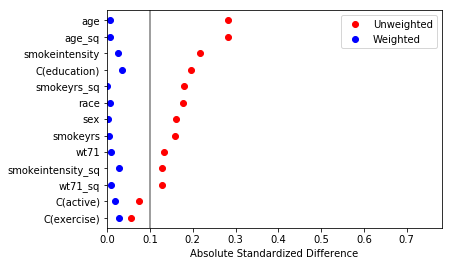

          Inverse Probability of Treatment Weight Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
Standard deviation can help in IPTW model selection
----------------------------------------------------------------------
Mean weight:            2.0
Standard Deviation:     1.47
Minimum weight:         1.05
Maximum weight:         16.7


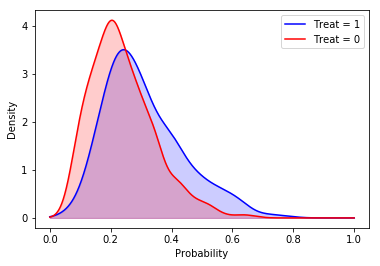

In [5]:
# diagnostics for weights
iptw.plot_love()
plt.show()

iptw.positivity(decimal=2)

iptw.plot_kde()
plt.show()

I ran some additional diagnostics in addition to what is discussed in the book. I created a Love plot, which assesses covariate balance measured by standardized mean differences. According to this measure, we have good balance by our measured covariates and weights. 

The IPTW diagnostics match what is described in the book results. The average weight of 2 (as expected) with an min of 1.05 and max of 16.7. 

Lastly, the density plot suggests there is a fair bit of overlap of propensity scores between treated and untreated. However, there are few treated individuals at the low end of the distribution and few untreated individuals at the higher end of the distribution

In [6]:
# estimation of marginal structural model
m = smf.gee('wt82_71 ~ qsmk', df.index, df, weights=iptw.Weight).fit()
beta = m.params[1]
lcl = np.round(m.conf_int()[0]['qsmk'], 2)
ucl = np.round(m.conf_int()[1]['qsmk'], 2)

print('Average Causal Effect')
print('--------------------------------------')
print('E[Y|A=1] - E[Y|A=0] = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Average Causal Effect
--------------------------------------
E[Y|A=1] - E[Y|A=0] =  3.44
95% CL: 2.41, 4.47
--------------------------------------


Similar to discussed in the book, we calculate confidence intervals using GEE with an independent correlation structure. This results in valid (but slightly conservative) confidence intervals. For further details see the book.

## Section 12.3
We will now repeat the analysis described in the previous section but using stabilized weights instead. Weights will now be constructed via the following formula
$$ \hat{w}_i = \frac{\widehat{\Pr}(A_i=a)}{\widehat{\Pr}(A_i=a | L_i)}$$
where the probability is estimated using a logistic regression model.

The only difference we make is that `IPTW` is initialized with `stabilized=True` instead

In [7]:
# initialize the IPTW and estimate weights
iptw = IPTW(df, treatment='qsmk', stabilized=True)
iptw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       print_results=False)
iptw.fit()

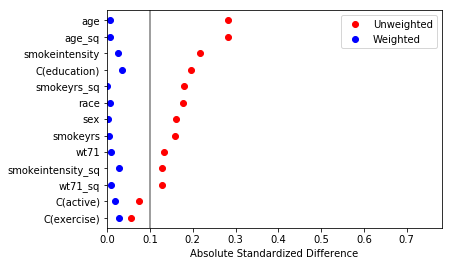

          Inverse Probability of Treatment Weight Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
Standard deviation can help in IPTW model selection
----------------------------------------------------------------------
Mean weight:            1.0
Standard Deviation:     0.29
Minimum weight:         0.33
Maximum weight:         4.3


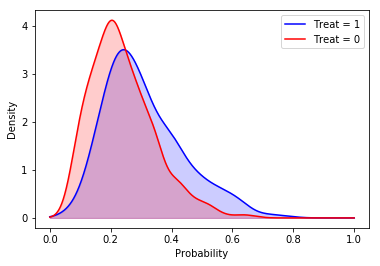

In [8]:
# diagnostics for weights
iptw.plot_love()
plt.show()

iptw.positivity(decimal=2)

iptw.plot_kde()
plt.show()

In [9]:
# estimation of marginal structural model
m = smf.gee('wt82_71 ~ qsmk', df.index, df, weights=iptw.Weight).fit()
beta = m.params[1]
lcl = np.round(m.conf_int()[0]['qsmk'], 2)
ucl = np.round(m.conf_int()[1]['qsmk'], 2)

print('Average Causal Effect')
print('--------------------------------------')
print('E[Y|A=1] - E[Y|A=0] = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Average Causal Effect
--------------------------------------
E[Y|A=1] - E[Y|A=0] =  3.44
95% CL: 2.41, 4.47
--------------------------------------


The estimate is the same in the previous section. As long as the marginal structural model is saturated, the unstabilized and stabilized IPTW should produce the same answer. While our results are the same, stabilized weights generally perform better with regards to precision. As such, *zEpid* defaults to calculating stabilized IPTW.

The diagnostics of "well-behaved" weights changes. Instead of a mean of 2, stabilized weights have a mean of 1.

## Section 12.4
### Continuous Treatments
Currently *zEpid* does not support continuous treatments for `IPTW`. This is a planned addition for the future.

The issue I have to work through is allowing sufficient flexibility of modeling choices for treatment. For these models you need the probability density function ($f(A|L)$), which can be hard to estimate correctly

### Binary Outcomes
Below is a demonstration of estimating the causal effect of quitting smoking (`qsmk`) on the risk of death (`death`). We already have our weights for quitting smoking and will assume the same set $L$ is sufficient for conditional exchangeability. For demonstration purposes, I will re-estimate the weights to keep all the code together

In [9]:
# initialize the IPTW and estimate weights
iptw = IPTW(df, treatment='qsmk', stabilized=True)
iptw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       print_results=False)
iptw.fit()

# estimation of marginal structural model
m = smf.gee('death ~ qsmk', df.index, df, weights=iptw.Weight, 
           family=sm.families.Binomial()).fit()
beta = np.exp(m.params[1])
lcl = np.round(np.exp(m.conf_int()[0]['qsmk']), 2)
ucl = np.round(np.exp(m.conf_int()[1]['qsmk']), 2)

print('Causal Odds Ratio')
print('--------------------------------------')
print('OR = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Causal Odds Ratio
--------------------------------------
OR =  1.03
95% CL: 0.76, 1.4
--------------------------------------


## Section 12.5
Now we will look at how to estimate effect modification. In the example, we are interested in effect modification by sex (`sex`) of quitting smoking (`qsmk`) on 10-year weight change (`wt71_82`). To do this, we will estimate the following marginal structural model
$$E[Y^a|V] = \beta_0 + \beta_1 a + \beta_2 V a + \beta_3 V$$
where $V$ is our modifier (sex)

We can conclude that there is additive effect modification if $\beta_2 \ne 0$. Note that this is no longer a *marginal* structural model, since we are actually conditioning on $V$ in the model. However, we still use the term MSM. For creating the weights, the set $L$ must contain $V$. We will construct the stabilized weights with the following formula. Note that I will write $V$ separate from $L$ to emphasize it is part of both the numerator and denominator
$$\hat{w}_i = \frac{\widehat{\Pr}(A_i=a|V_i)}{\widehat{\Pr}(A=a|V_i, L_i)}$$
For estimation of these new weights in *zEpid*, we will add another optional argument. This argument is part of the regression model statement. We will specify `model_numerator='sex'`, which tells *zEpid* that we want the conditional probability in the numerator.

Lastly, we will use some additional `patsy` magic to reduce the recoding we need to do. Specificially we will use `:` to generate an interaction term in our marginal structural model

In [10]:
# initialize the IPTW and estimate weights
iptw = IPTW(df, treatment='qsmk', stabilized=True)
iptw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       model_numerator='sex',
                       print_results=False)
iptw.fit()

# estimation of faux marginal structural model
m = smf.gee('wt82_71 ~ qsmk + sex + qsmk:sex', df.index, df, weights=iptw.Weight).fit()
print(m.summary())

                               GEE Regression Results                              
Dep. Variable:                     wt82_71   No. Observations:                 1566
Model:                                 GEE   No. clusters:                     1566
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                           Gaussian   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 02 Apr 2019   Scale:                          60.953
Covariance type:                    robust   Time:                         14:21:40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7844      0.310      5.759      0.000       1.177       2.392
qsmk   

The $\beta$ for interaction was -0.16 (95% CL: -2.21, 1.89), indicating that there is not strong evidence for effect modification by gender

## Section 12.6
Going back to the start, we excluded 63 individuals with missing weights at 1982. However, this can result in selection bias. We will now use inverse probability of missing weights to relax the current assumption of 1982 weights missing completely at random. We will do this by using `IPMW`.

Our new weights (to simultaneously adjust for confounders and accounting for missing at random weights) will have the following form
$$\hat{w}_i^* = \frac{1}{\widehat{\Pr}(M=0|L,A)} \times \frac{1}{\widehat{\Pr}(A=a|L_i)}$$
where $M$ is an indicator whether the person has a missing weight in 1982. We can also calculate stabilized weights via the following
$$\hat{w}_i^* = \frac{\widehat{\Pr}(M=0|A)}{\widehat{\Pr}(M=0|L,A)} \times \frac{\widehat{\Pr}(A_i=a)}{\widehat{\Pr}(A=a| L_i)}$$

We will estimate IPMW by using `IPMW`. `IPMW` has a similar syntax structure to `IPTW`. One nice thing about `IPMW` is that it automatically detects missing data for us. We only need to provide the variable(s) that have missing data. Not to get sidetracked, but `IPMW` also supports monotonic missing data (with plans to include non-monotonic missing data in the future). Let's demonstrate `IPMW` for a single missing variable with unstabilized weights first

In [11]:
# Reloading the data (including 1982 weight missing)
df = pd.read_csv('Data/nhefs.csv')
df.dropna(subset=['sex', 'age', 'race', 'ht', 
                  'school', 'alcoholpy', 'smokeintensity'], 
         inplace=True)

# recoding some variables
df['inactive'] = np.where(df['active'] == 2, 1, 0)
df['no_exercise'] = np.where(df['exercise'] == 2, 1, 0)
df['university'] = np.where(df['education'] == 5, 1, 0)

# creating quadratic terms
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    df[col+'_sq'] = df[col] * df[col]


In [12]:
# Calculating IPMW
ipmw = IPMW(df, missing_variable='wt82_71', stabilized=False)
ipmw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq + qsmk', 
                       print_results=False)
ipmw.fit()

# Calculating IPTW
iptw = IPTW(df, treatment='qsmk', stabilized=False)
iptw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       print_results=False)
iptw.fit()

# estimation of marginal structural model
m = smf.gee('wt82_71 ~ qsmk', df.index, df, weights=iptw.Weight*ipmw.Weight).fit()
beta = m.params[1]
lcl = np.round(m.conf_int()[0]['qsmk'], 2)
ucl = np.round(m.conf_int()[1]['qsmk'], 2)

print('Average Causal Effect')
print('--------------------------------------')
print('E[Y|A=1] - E[Y|A=0] = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Average Causal Effect
--------------------------------------
E[Y|A=1] - E[Y|A=0] =  3.5
95% CL: 2.47, 4.53
--------------------------------------


Now I will repeat the same process, but will use stabilized weights instead

In [13]:
# Calculating IPMW
ipmw = IPMW(df, missing_variable='wt82_71', stabilized=True)
ipmw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq + qsmk', 
                       model_numerator='qsmk',
                       print_results=False)
ipmw.fit()

# Calculating IPTW
iptw = IPTW(df, treatment='qsmk', stabilized=True)
iptw.regression_models('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       print_results=False)
iptw.fit()

# estimation of marginal structural model
m = smf.gee('wt82_71 ~ qsmk', df.index, df, weights=iptw.Weight*ipmw.Weight).fit()
beta = m.params[1]
lcl = np.round(m.conf_int()[0]['qsmk'], 2)
ucl = np.round(m.conf_int()[1]['qsmk'], 2)

print('Average Causal Effect')
print('--------------------------------------')
print('E[Y|A=1] - E[Y|A=0] = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Average Causal Effect
--------------------------------------
E[Y|A=1] - E[Y|A=0] =  3.5
95% CL: 2.47, 4.53
--------------------------------------


## Conclusion
That concludes chapter 12 of "Causal Inference" by Hernan and Robins. Please review the other tutorials on this site for more details and features of `IPTW`, `IPMW`, and other functionalities. In the next tutorial, we will go through the parametric g-formula